# How to useTatukGIS DK for Python in Jupter Notebook

### Import TatukGIS and other modules

In [1]:
import tatukgis.pdk as pdk
from IPython import display
from tqdm.notebook import tqdm
from time import sleep

### Create GIS viewer and open project

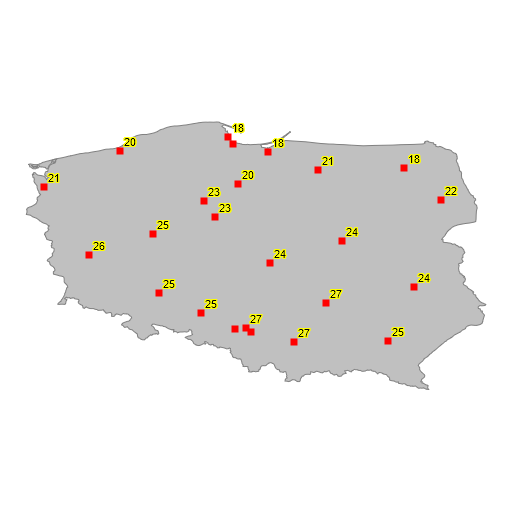

In [2]:
gis = pdk.TGIS_ViewerBmp(512, 512)
gis.Open(pdk.TGIS_Utils.GisSamplesDataDirDownload() + 'Samples/Interpolation/Interpolation.ttkproject')
gis.GIS_Bitmap.AsPng()

display.Image(gis.GIS_Bitmap.AsPng())

### Modify map properties and elemets 

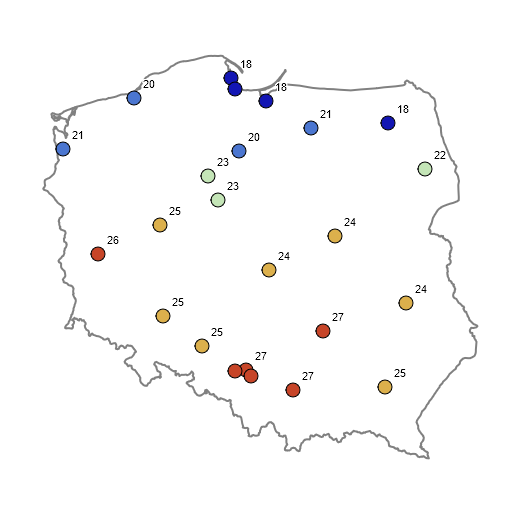

In [3]:
# change boundary (polygon) symbology
country_layer = gis.Get("country")
country_layer.Params.Area.Pattern = pdk.TGIS_BrushStyle().Clear
country_layer.Params.Area.Color = pdk.TGIS_Color.FromString("#36454F")
country_layer.Params.Area.OutlineWidthAsText = "size:1.5pt"

# change point symbology and label proprties   
temperatures_layer = gis.Get("temperatures")
temperatures_layer.Params.Marker.Style = pdk.TGIS_MarkerStyle().Circle
temperatures_layer.Params.Marker.SizeAsText = "size:14px"
temperatures_layer.Params.Marker.OutlineWidthAsText = "size:1px"
temperatures_layer.Params.Marker.OutlineColor = pdk.TGIS_Color.Black
temperatures_layer.Params.Labels.Color = pdk.TGIS_Color.FromString("#FFF")  # white
# temperatures_layer.Params.Labels.FontColor = pdk.TGIS_Color.FromRGB(0, 0, 0)  # black

# use data classification trechniques to visualize temperature from point vector layer   
classifier = pdk.TGIS_ClassificationFactory.CreateClassifier(temperatures_layer)
classifier.Target = "TEMP"
classifier.Method = pdk.TGIS_ClassificationMethod().EqualInterval
color_ramp = pdk.TGIS_Utils.GisColorRampList.ByName('Temperature').RealizeColorMap(
    pdk.TGIS_ColorMapMode().Continuous,
    5,
    False
)
classifier.ColorRamp = color_ramp
# data classification process is based on layer's statistics,
# so these statistics must be available
if classifier.MustCalculateStatistics():
    temperatures_layer.Statistics.Calculate()
classifier.Classify()

# change viewer's spatial reference
gis.CS = pdk.TGIS_CSFactory.ByEPSG(2180)
gis.FullExtent()

display.Image(gis.GIS_Bitmap.AsPng())

### Prepare destination grid layer

In [4]:
# remove any previously created grid layer
if gis.Get("grid"):
    gis.Delete("grid")

# calculate the widht and height of the grid layer based on country_layer extent
extent = country_layer.Extent
ratio = (extent.YMax - extent.YMin)/(extent.XMax - extent.XMin)
grid_width = 1000
grid_height = round(grid_width * ratio)
    
# create and initialize the destination layer
grid_layer = pdk.TGIS_LayerPixel()
grid_layer.Name = "grid"
grid_layer.Build(True, temperatures_layer.CS, extent, grid_width, grid_height)
grid_layer.Params.Pixel.GridShadow = False

### Add progress bar support

In [5]:
def doProgress(sender, pos, end, abort):
    # initialize progress
    if pos == 0:
        pbar.reset(total=end)
    elif pos == -1:
        pbar.n = 100
        pbar.update(0)
        pbar.close()  
    else:
        pbar.n = pos
        pbar.update(0)

    sleep(0.1)

### Perform Kriging interpolation

0it [00:00, ?it/s]

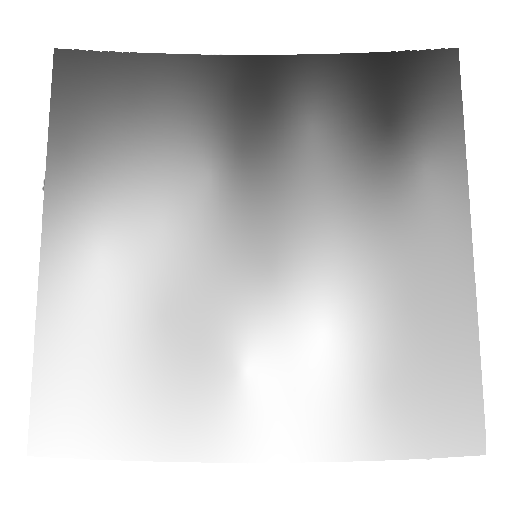

In [6]:
# create tqdm progress bar 
pbar = tqdm()

# do kriging
kriging = pdk.TGIS_InterpolationKriging()
kriging.BusyEvent = doProgress
kriging.Generate(temperatures_layer, extent, "TEMP", grid_layer, extent)

# add the grid layer to the viewer
gis.Add(grid_layer)

# turn off temperature layer
temperatures_layer.Active = False
gis.InvalidateWholeMap()
display.Image(gis.GIS_Bitmap.AsPng())

### Adjust the grid layer visualization

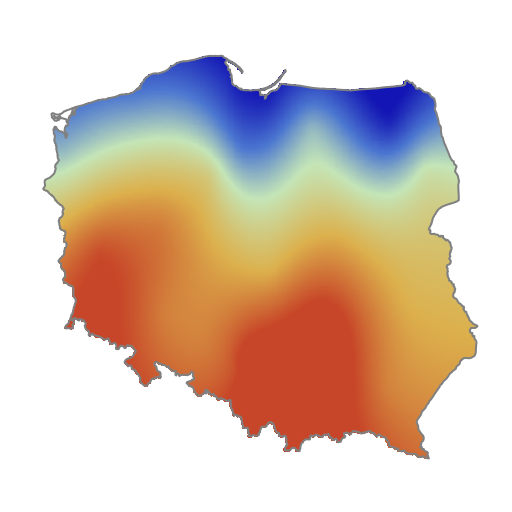

In [7]:
# create classfier and set properties
classifier = pdk.TGIS_ClassificationFactory.CreateClassifier(grid_layer)
classifier.Method = pdk.TGIS_ClassificationMethod().EqualInterval
classifier.ColorRamp = color_ramp
if classifier.MustCalculateStatistics():
    grid_layer.Statistics.Calculate()
classifier.Classify()

grid_layer.Params.Pixel.GridSmoothColors = True

# limit the grid visibility only to the pixels contained within a polygon
cutting_polygon = country_layer.GetShape(6).CreateCopy()
grid_layer.CuttingPolygon = cutting_polygon

# move grid layer to the bottom
grid_layer.ZOrder = 2

# update the viewer to show the grid layer
gis.InvalidateWholeMap()
display.Image(gis.GIS_Bitmap.AsPng())

### Generate contours from the grid layer 

0it [00:00, ?it/s]

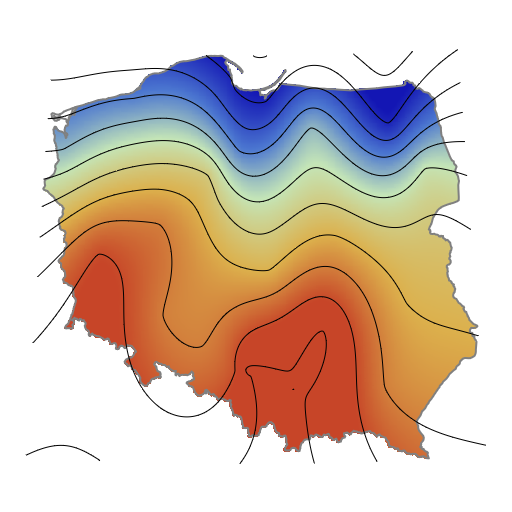

In [8]:
# prepare a vector layer for contours 
contour_layer = pdk.TGIS_LayerVector()
contour_layer.Name = 'contours'
contour_layer.CS = grid_layer.CS

# use TGIS_ContourGenerator for creating contour lines
contour_generator = pdk.TGIS_ContourGenerator()
contour_generator.ContourInterval = 1.0
contour_generator.Smoothen = True
pbar = tqdm()
contour_generator.BusyEvent = doProgress
contour_generator.Generate(grid_layer, contour_layer, '')
  
# add new layer and refresh the viewer
gis.Add(contour_layer)
gis.InvalidateWholeMap()
display.Image(gis.GIS_Bitmap.AsPng())

### Clip contours by country boundary

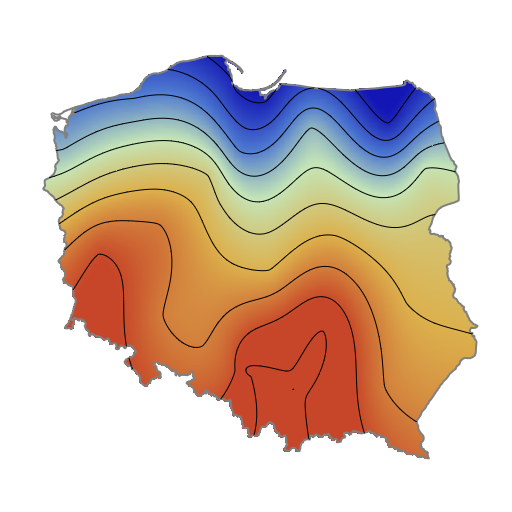

In [9]:
for shp in contour_layer.Loop():
    shp_edit = shp.MakeEditable()
    shp_edit.Intersection(cutting_polygon, False)
    
gis.InvalidateWholeMap()
display.Image(gis.GIS_Bitmap.AsPng())